Final jupyter file

Students: Nurlan Marat, Aiym Tleuberdinova, Amina Rysbekova

Group: BDA-2302

link for database: https://drive.google.com/file/d/1CPZM7OmIJUaAJhAP460Epcfu2xonW4uA/view?usp=sharing

link github: https://github.com/Nurlan3007/Classificationn-chest-x-ray

Задача — классификация рентгена легких на 3 класса: норм, пневмония, туберкулез

Metrics report находиться в конце файла


In [1]:
# импортируем все необходимые модули
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm # это нужно для красивого отображения прогресса в циклах
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
import matplotlib.pyplot as plt


In [3]:
# Используем GPU вместо cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

🔥 Using device: cuda


In [6]:
data_dir = "C:/Users/HP/Desktop/finalAML/datasets"  # полный путь до паппок с train/val/test
batch_size = 128 # размер каждого батча
num_epochs = 25 # количество эпох для обучения
learning_rate = 0.002 
num_classes = 3 # количество классов которые нужно предсказать (пневмония туберкулез и норм)

In [7]:
# настройки для preprocessing последовательность преобразований 
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),# перевод из rgb в серый цвет с одним значением вместо трех
    transforms.Resize((128, 128)), # изменил размер изображения для ускорения обучения
    transforms.RandomHorizontalFlip(), # случайное отражение изображения по горизонтали
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), # перевод в тензор
    transforms.Normalize([0.5], [0.5]) 
])

val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(f"{data_dir}/val", transform=val_test_transforms)
test_dataset = datasets.ImageFolder(f"{data_dir}/test", transform=val_test_transforms)

print(f"Datasets loaded: {len(train_dataset)}-train; {len(val_dataset)}-val; {len(test_dataset)}-test")
print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader.dataset) )

Datasets loaded: 20450-train; 2534-val; 2569-test
{'normal': 0, 'pneumonia': 1, 'tuberculosis': 2}
{'normal': 0, 'pneumonia': 1, 'tuberculosis': 2}
20450


In [ ]:
# реализовал кастомную модель CNN
# 1. Convolutional Layers
# Назначение: Извлечение пространственных признаков из изображений
# Реализация: Ядра 3×3 с padding=1
# Результат: Иерархическое обучение признакам (рёбра → текстуры → шаблоны)
# 2. Batch Normalization
# Назначение: Нормализация входных данных слоя для стабильного обучения
# Реализация: После каждого свёрточного слоя
# Результат: Более быстрая сходимость, возможна более высокая скорость обучения
# 3. Pooling Layers
# Назначение: Уменьшение пространственных измерений, обеспечение инвариантности к трансляции
# Реализация: MaxPool2d(2, 2) — уменьшает размер вдвое
# Результат: Вычислительная эффективность, устойчивость к шуму
# 4. Activation Functions
# Назначение: Внесение нелинейности
# Реализация: ReLU(inplace=True)
# Результат: Позволяет изучать сложные шаблоны
# 5. Dropout
# Назначение: Регуляризация для предотвращения переобучения
# Реализация: Dropout(0,5) и Dropout(0,3)
# Результат: Лучшая обобщенность для ранее не наблюдавшихся данных

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # извлекаем признаки, испольузуем 3х3 фильтры потому-что он хорошо находит локальные особенности
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  
            nn.ReLU(), # фнкция активации нужна чтобы убрать линейность
            nn.MaxPool2d(2, 2), # уменьшение размерности
            nn.Dropout(0.25), # отключаем 1/4 нейронов для борьбы с переобучением

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # переводет многомерный тензор в одномерный тензор 
            nn.Linear(128 * 8 * 8, 256), # 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x): # прямой проход через сеть
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomCNN(num_classes=num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() # функция потерь для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # оптимизатор Adam
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses = [], []
train_accs, val_accs = [], []


In [ ]:
# Создаем папки для чекпоинтов и лучших моделей
checkpoint_dir = "C:/Users/HP/Desktop/finalAML/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = float("inf")
patience_counter = 0
save_every = 2 

best_dir = "C:/Users/HP/Desktop/finalAML/best_model"
os.makedirs(best_dir, exist_ok=True)


In [ ]:
# Цикл обучение и валидации
for epoch in range(num_epochs):
    model.train() # перевод в режим обучения
    running_loss, running_corrects = 0.0, 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False) # прогресс бар
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # обнуляем градиенты
        outputs = model(inputs) # делаем предсказания
        loss = criterion(outputs, labels) # считаем ошибку
        loss.backward() # считаем градиенты
        optimizer.step() # обновляем веса

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # Валидация
    model.eval() # перевод в режим оценки
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad(): # отключаем градиенты для ускорения вычислений
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)AQ3
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())

    scheduler.step()

    # Сохраняем лучшую модель если лосс меньше прошлый
    if val_epoch_loss < best_loss:
        best_path = os.path.join(best_dir, f"best{epoch+1}.pth")
        patience_counter = 0
        best_loss = val_epoch_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_loss': best_loss,
        }, best_path)
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Early stopping triggered.")
            break

    if (epoch + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, checkpoint_path)
        print(f"Checkpoint_saved {checkpoint_path}")

    print(f"Epoch {epoch+1}/{num_epochs} "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
        f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")



Epoch 1/25 Train Loss: 0.7386 | Train Acc: 0.6300 | Val Loss: 0.5820 | Val Acc: 0.7064


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_2.pth
Epoch 2/25 Train Loss: 0.5608 | Train Acc: 0.7155 | Val Loss: 0.5267 | Val Acc: 0.7218


Epoch 3/25 Train Loss: 0.5215 | Train Acc: 0.7280 | Val Loss: 0.5185 | Val Acc: 0.7289


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_4.pth
Epoch 4/25 Train Loss: 0.4961 | Train Acc: 0.7337 | Val Loss: 0.4970 | Val Acc: 0.7372


Epoch 5/25 Train Loss: 0.4824 | Train Acc: 0.7444 | Val Loss: 0.4676 | Val Acc: 0.7470


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_6.pth
Epoch 6/25 Train Loss: 0.4645 | Train Acc: 0.7471 | Val Loss: 0.4561 | Val Acc: 0.7435


Epoch 7/25 Train Loss: 0.4581 | Train Acc: 0.7539 | Val Loss: 0.4510 | Val Acc: 0.7494


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_8.pth
Epoch 8/25 Train Loss: 0.4567 | Train Acc: 0.7540 | Val Loss: 0.4467 | Val Acc: 0.7534


Epoch 9/25 Train Loss: 0.4536 | Train Acc: 0.7542 | Val Loss: 0.4395 | Val Acc: 0.7541


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_10.pth
Epoch 10/25 Train Loss: 0.4500 | Train Acc: 0.7556 | Val Loss: 0.4456 | Val Acc: 0.7490


Epoch 11/25 Train Loss: 0.4416 | Train Acc: 0.7616 | Val Loss: 0.4393 | Val Acc: 0.7557


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_12.pth
Epoch 12/25 Train Loss: 0.4395 | Train Acc: 0.7601 | Val Loss: 0.4337 | Val Acc: 0.7545


Epoch 13/25 Train Loss: 0.4383 | Train Acc: 0.7616 | Val Loss: 0.4328 | Val Acc: 0.7553


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_14.pth
Epoch 14/25 Train Loss: 0.4364 | Train Acc: 0.7600 | Val Loss: 0.4351 | Val Acc: 0.7549


Epoch 15/25 Train Loss: 0.4337 | Train Acc: 0.7630 | Val Loss: 0.4257 | Val Acc: 0.7569


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_16.pth
Epoch 16/25 Train Loss: 0.4309 | Train Acc: 0.7661 | Val Loss: 0.4299 | Val Acc: 0.7549


Epoch 17/25 Train Loss: 0.4298 | Train Acc: 0.7653 | Val Loss: 0.4278 | Val Acc: 0.7565


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_18.pth
Epoch 18/25 Train Loss: 0.4291 | Train Acc: 0.7631 | Val Loss: 0.4248 | Val Acc: 0.7565


Epoch 19/25 Train Loss: 0.4279 | Train Acc: 0.7662 | Val Loss: 0.4273 | Val Acc: 0.7605


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_20.pth
Epoch 20/25 Train Loss: 0.4287 | Train Acc: 0.7664 | Val Loss: 0.4300 | Val Acc: 0.7557


Epoch 21/25 Train Loss: 0.4263 | Train Acc: 0.7681 | Val Loss: 0.4225 | Val Acc: 0.7565


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_22.pth
Epoch 22/25 Train Loss: 0.4265 | Train Acc: 0.7664 | Val Loss: 0.4235 | Val Acc: 0.7620


Epoch 23/25 Train Loss: 0.4254 | Train Acc: 0.7667 | Val Loss: 0.4219 | Val Acc: 0.7589


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_24.pth
Epoch 24/25 Train Loss: 0.4232 | Train Acc: 0.7694 | Val Loss: 0.4230 | Val Acc: 0.7581


Epoch 25/25 Train Loss: 0.4241 | Train Acc: 0.7677 | Val Loss: 0.4223 | Val Acc: 0.7561


Дообучаем модель при помощи уменьшение learning rate чтобы пройти плот максимум

In [27]:
best_path = "C:/Users/HP/Desktop/finalAML/best_model/best23.pth"

if os.path.exists(best_path):
    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Resumed from epoch {checkpoint['epoch']}")
else:
    print("No found path")

C:\Users\HP\AppData\Local\Temp\ipykernel_23416\2893962628.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_path, map_location=device)


Resumed from epoch 23


In [ ]:
best_loss = float("inf")

learning_rate = 0.0001  #0.002 уменьшаем learning rate для дообучения
num_epochs = 35
start_epoch = checkpoint['epoch']

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# после того как я дообучил модель на 25 эпохах я заметил что класс туберкулеза хуже всего предсказывается
# поэтому я решил вернуться добавить веса для классов чтобы модель больше штрафов получала за ошибки на этом классе

class_weights = torch.tensor([1.2, 1.0, 1.4]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        
    factor=0.5,       
    patience=2,       
    verbose=True      
) # уменьшаем learning rate если валидация ошибки не уменьшается

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [208]:
for epoch in range(start_epoch,num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # Валидация
    model.eval() # перевод в режим оценки
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())

    scheduler.step(val_epoch_loss)

    if val_epoch_loss < best_loss:
        best_path = os.path.join(best_dir, f"best{epoch+1}.pth")
        patience_counter = 0
        best_loss = val_epoch_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_loss': best_loss,
        }, best_path)

    if (epoch + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, checkpoint_path)
        print(f"Checkpoint_saved {checkpoint_path}")

    print(f"Epoch {epoch+1}/{num_epochs} "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
        f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")



Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_24.pth
Epoch 24/35 Train Loss: 0.4275 | Train Acc: 0.7650 | Val Loss: 0.4251 | Val Acc: 0.7632


Epoch 25/35 Train Loss: 0.4282 | Train Acc: 0.7645 | Val Loss: 0.4245 | Val Acc: 0.7628


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_26.pth
Epoch 26/35 Train Loss: 0.4297 | Train Acc: 0.7665 | Val Loss: 0.4248 | Val Acc: 0.7656


Epoch 27/35 Train Loss: 0.4282 | Train Acc: 0.7661 | Val Loss: 0.4237 | Val Acc: 0.7593


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_28.pth
Epoch 28/35 Train Loss: 0.4277 | Train Acc: 0.7633 | Val Loss: 0.4248 | Val Acc: 0.7569


Epoch 29/35 Train Loss: 0.4285 | Train Acc: 0.7643 | Val Loss: 0.4238 | Val Acc: 0.7624


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_30.pth
Epoch 30/35 Train Loss: 0.4278 | Train Acc: 0.7661 | Val Loss: 0.4239 | Val Acc: 0.7628


Epoch 31/35 Train Loss: 0.4252 | Train Acc: 0.7674 | Val Loss: 0.4234 | Val Acc: 0.7664


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_32.pth
Epoch 32/35 Train Loss: 0.4272 | Train Acc: 0.7648 | Val Loss: 0.4228 | Val Acc: 0.7616


Epoch 33/35 Train Loss: 0.4265 | Train Acc: 0.7630 | Val Loss: 0.4225 | Val Acc: 0.7601


Checkpoint_saved C:/Users/HP/Desktop/finalAML/checkpoints\checkpoint_epoch_34.pth
Epoch 34/35 Train Loss: 0.4262 | Train Acc: 0.7660 | Val Loss: 0.4214 | Val Acc: 0.7609


Epoch 35/35 Train Loss: 0.4264 | Train Acc: 0.7659 | Val Loss: 0.4226 | Val Acc: 0.7624


Смотря на результат можно сделать вывод что модель выжата по максимуму

Выводим метрики 

In [10]:
best_path = "C:/Users/HP/Desktop/finalAML/best_model/best34.pth"
# best_path = "C:/Users/HP/Desktop/finalAML/checkpoints/checkpoint_epoch_34.pth"

if os.path.exists(best_path):
    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Resumed from epoch {checkpoint['epoch']}")
else:
    print("No found path")

Resumed from epoch 34


C:\Users\HP\AppData\Local\Temp\ipykernel_23416\1752505236.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_path, map_location=device)


In [11]:
all_preds = []
all_labels = []
# Оценка на тестовом наборе
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


[1317  544  708]
[ 925  580 1064]


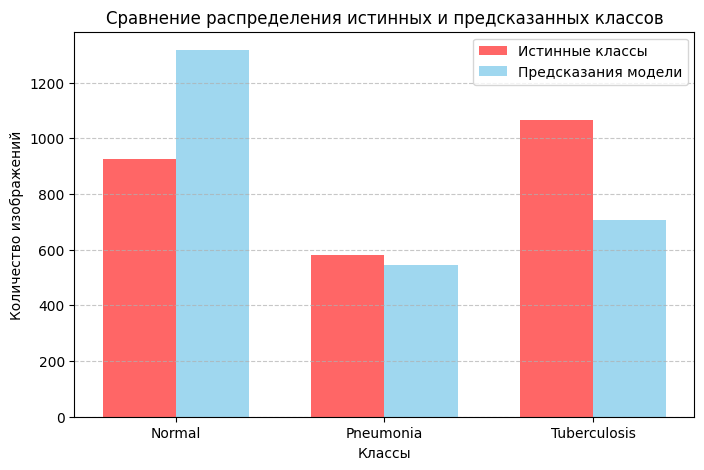

In [26]:
import numpy as np

num_classes = 3
classes = ['Normal', 'Pneumonia', 'Tuberculosis']
x = np.arange(num_classes) 
width = 0.35  

pred_counts = np.bincount(all_preds, minlength=num_classes)
print(pred_counts)
label_counts = np.bincount(all_labels, minlength=num_classes)
print(label_counts)
plt.figure(figsize=(8,5))

plt.bar(x - width/2, label_counts, width, color='red', alpha=0.6, label='Истинные классы')

plt.bar(x + width/2, pred_counts, width, color='skyblue', alpha=0.8, label='Предсказания модели')

# Настройки осей и оформления
plt.xticks(x, classes)
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Сравнение распределения истинных и предсказанных классов')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [212]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("---"*54)
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

Accuracy: 0.7614
Precision: 0.8084
Recall: 0.7614
F1-score: 0.7634
------------------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.62      0.88      0.73       925
   Pneumonia       0.88      0.82      0.85       580
Tuberculosis       0.93      0.62      0.75      1064

    accuracy                           0.76      2569
   macro avg       0.81      0.78      0.78      2569
weighted avg       0.81      0.76      0.76      2569



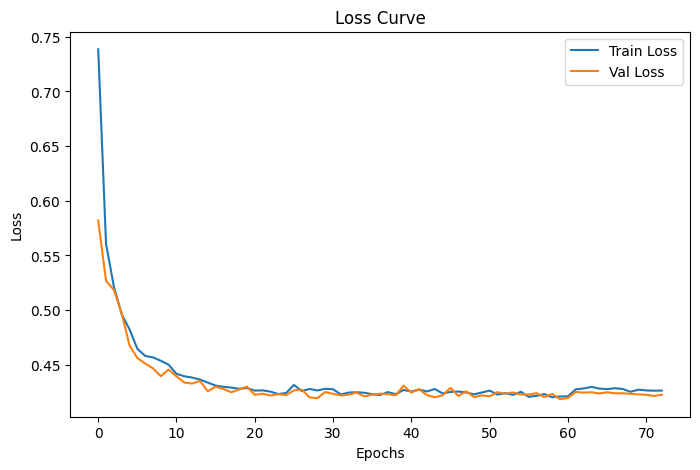

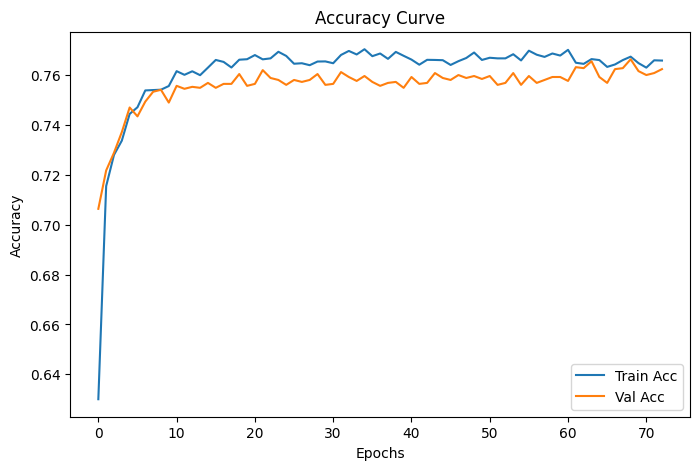

In [214]:
# Loss curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

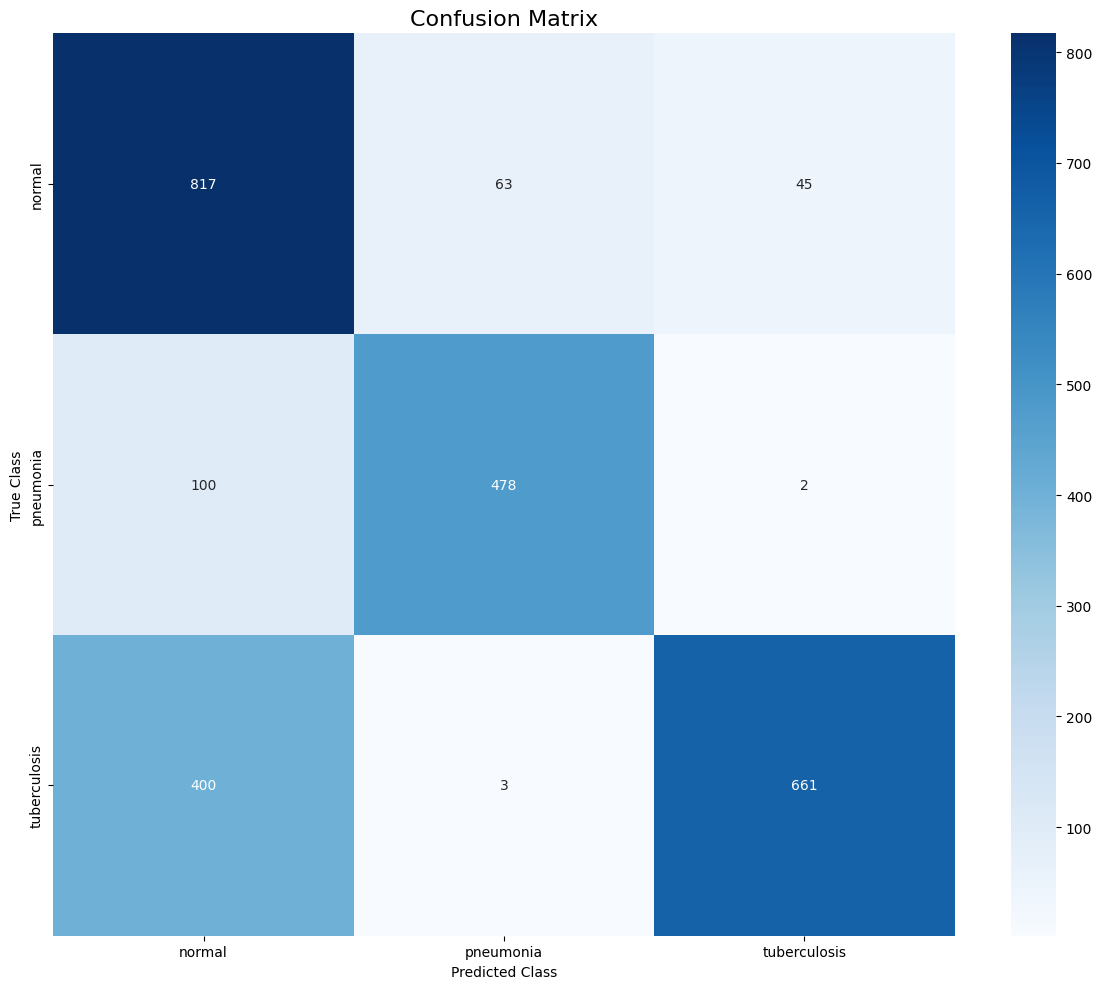

In [215]:
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=val_loader.dataset.classes, 
            yticklabels=val_loader.dataset.classes)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()